# Supervised Machine Learning Project
## CUSSON Thomas - MARMORET Axel

In [1]:
# All the needed imports
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import CountVectorizer
import random
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import scikitplot as skplt

# The differents algorithms
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Load the data

In [2]:
reviewList = []

mydir = "../Datasets/petit/txt_sentoken/" # Could need to change the path

# Load the positive examples 
for txt in listdir(mydir + "pos/"):
    if isfile(join(mydir + "pos/", txt)):
        review = open(join(mydir + "pos/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 0))
        
# Load the negative examples
for txt in listdir(mydir + "neg/"):
    if isfile(join(mydir + "neg/", txt)):
        review = open(join(mydir + "neg/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 1))
        

## Pre-format the data

In [3]:
# Shuffle the positive and negative examples
random.seed(3)
random.shuffle(reviewList)

# Use first 70% for training
train_size =int(0.7 * len(reviewList))
train_set, test_set = reviewList[:train_size], reviewList[train_size:]
        
# Split the datasets in usable tables
train_set_unlabeled,train_labels,test_set_unlabeled,test_labels = [], [], [], []

for i in range(len(train_set)) :
    train_set_unlabeled.append(train_set[i][0])
    train_labels.append(train_set[i][1])
for i in range(len(test_set)) :
    test_set_unlabeled.append(test_set[i][0])
    test_labels.append(test_set[i][1])

# Machine Learning algorithms

## Naive Bayes

### Test different parameters

In [4]:
# Pipeline of action specific for the Naive Bayes algorithm
pipeline_nb = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=15, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB()),
                    ])

# NB : We have run our algorithm with min_df as a parameter in order to find its best value
# It gaves us 16 in range (1,51,5) and 15 in range (13, 19)
# This parameter exploded our computation time, so we decided to fixed it at 15 in order to run our algorithms in decent time

# GridSearch allows us to test severals parameters
parameters_nb = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'tfidf__use_idf': (True, False),
                 'nb__alpha': (1e-1, 1e-2),
}

GridSearchNaiveBayse = GridSearchCV(pipeline_nb, parameters_nb, n_jobs=-1, cv = 3)

### Run the test pipeline !

In [5]:
GridSearchNaiveBayse = GridSearchNaiveBayse.fit(train_set_unlabeled, train_labels)

### Looking at the best parameters

In [6]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, GridSearchNaiveBayse.best_params_[param_name]))

print("Best Estimator : " + str(GridSearchNaiveBayse.best_estimator_.get_params()["nb"]))

print ("Best Score on those conditions : " + str(GridSearchNaiveBayse.best_score_))

nb__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 1)
Best Estimator : MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Best Score on those conditions : 0.8071428571428572


### Keeping the best estimator according to the parameters

In [7]:
naive = GridSearchNaiveBayse.best_estimator_

### Test the prediction on our test set

Accuracy : 0.7916666666666666


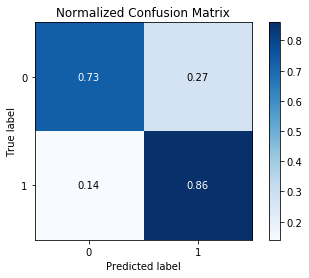

Recall : 0.7363636363636363
Precision : 0.8647686832740213


In [8]:
test_bayse_prediction = naive.predict(test_set_unlabeled)

print("Accuracy : " + str(metrics.accuracy_score(test_bayse_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_bayse_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_bayse_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_bayse_prediction, test_labels)))

ROC_Score : 0.7978114478114477


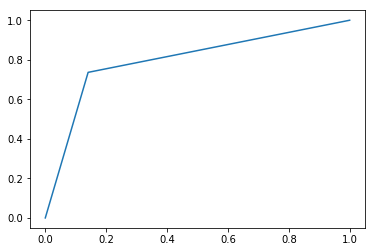

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(test_bayse_prediction, test_labels)
plt.figure()
plt.plot(fpr, tpr)

print("ROC_Score : " + str(metrics.roc_auc_score(test_bayse_prediction, test_labels)))


### Text analysis

In [10]:
words = naive.get_params()["vect"].get_feature_names()

# number of times each word appears across all positive messages
pos_word_count = naive.get_params()["nb"].feature_count_[0, :]

neg_word_count = naive.get_params()["nb"].feature_count_[1, :]

ratio_pos_neg = []
for i in range(len(pos_word_count)) :
    ratio_pos_neg.append(pos_word_count[i]/neg_word_count[i])

words_frequencies = pd.DataFrame({"word":words, "positive":pos_word_count, "negative":neg_word_count, "ratio":ratio_pos_neg}).set_index("word")
words_frequencies.head()

words_frequencies.sort_values('ratio', ascending=False)

'words = naive.get_params()["vect"].get_feature_names()\n\n# number of times each word appears across all positive messages\npos_word_count = naive.get_params()["nb"].feature_count_[0, :]\n\nneg_word_count = naive.get_params()["nb"].feature_count_[1, :]\n\nratio_pos_neg = []\nfor i in range(len(pos_word_count)) :\n    ratio_pos_neg.append(pos_word_count[i]/neg_word_count[i])\n\nwords_frequencies = pd.DataFrame({"word":words, "positive":pos_word_count, "negative":neg_word_count, "ratio":ratio_pos_neg}).set_index("word")\nwords_frequencies.head()\n\nwords_frequencies.sort_values(\'ratio\', ascending=False)'

## SVM

### We know use the same operating procedure

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


svc__C: 1
svc__gamma: 0.1
svc__kernel: 'linear'
tfidf__use_idf: True
vect__ngram_range: (1, 2)
 Best Estimator : SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy : 0.8216666666666667


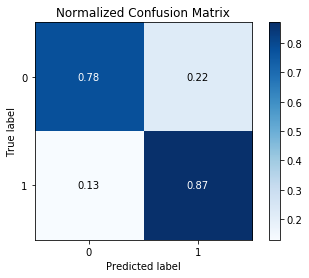

Recall : 0.7770700636942676
Precision : 0.8683274021352313
ROC_Score : 0.8238497171618191


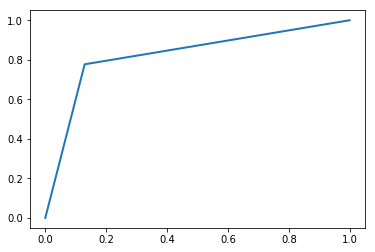

In [11]:
# Fitting
pipeline_svm = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=15, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('svc', SVC()),
                    ])

parameters_svm = {'tfidf__use_idf': (True, False),
                  'vect__ngram_range': [(1, 1), (1, 2)],
                  'svc__kernel': ['linear','rbf'],
                  'svc__gamma': [0.1, 0.01],
                  'svc__C': [1, 10, 100],
}

GridSearchSVM = GridSearchCV(pipeline_svm, parameters_svm, n_jobs=-1)

GridSearchSVM.fit(train_set_unlabeled, train_labels)

# Best estimator
for param_name in sorted(parameters_svm.keys()):
    print("%s: %r" % (param_name, GridSearchSVM.best_params_[param_name]))

print(" Best Estimator : " + str(GridSearchSVM.best_estimator_.get_params()["svc"]))

svm = GridSearchSVM.best_estimator_

# Prediction on test set
test_svm_prediction = svm.predict(test_set_unlabeled)

# Results
print("Accuracy : " + str(metrics.accuracy_score(test_svm_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_svm_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_svm_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_svm_prediction, test_labels)))

fpr, tpr, thresholds = metrics.roc_curve(test_svm_prediction, test_labels)
plt.figure()
plt.plot(fpr, tpr, lw=2)

print("ROC_Score : " + str(metrics.roc_auc_score(test_svm_prediction, test_labels)))


## Random Forest 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


rf__n_estimators: 2000
tfidf__use_idf: False
vect__ngram_range: (1, 1)
 Best Estimator : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy : 0.82


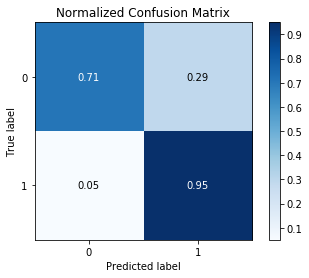

Recall : 0.7409470752089137
Precision : 0.9466192170818505
ROC_Score : 0.8393532056542494


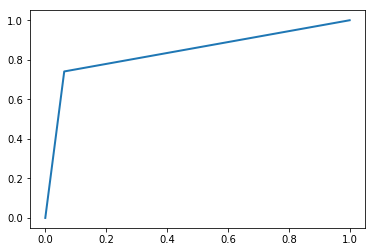

In [12]:
# Fitting
pipeline_rf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=15, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier()),
                    ])

parameters_rf = {'tfidf__use_idf': (True, False),
                 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'rf__n_estimators': [100, 1000, 2000],
}

GridSearchRF = GridSearchCV(pipeline_rf, parameters_rf, n_jobs=-1)

GridSearchRF.fit(train_set_unlabeled, train_labels)

# Best estimator
for param_name in sorted(parameters_rf.keys()):
    print("%s: %r" % (param_name, GridSearchRF.best_params_[param_name]))

print(" Best Estimator : " + str(GridSearchRF.best_estimator_.get_params()["rf"]))

rf = GridSearchRF.best_estimator_

# Prediction on test set
test_rf_prediction = rf.predict(test_set_unlabeled)

# Results
print("Accuracy : " + str(metrics.accuracy_score(test_rf_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_rf_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_rf_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_rf_prediction, test_labels)))

fpr, tpr, thresholds = metrics.roc_curve(test_rf_prediction, test_labels)
plt.figure()
plt.plot(fpr, tpr, lw=2)

print("ROC_Score : " + str(metrics.roc_auc_score(test_rf_prediction, test_labels)))


## Gradient Boosting

In [13]:
# Fitting
"""pipeline_gb = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=15, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('gb', GradientBoostingClassifier()),
                    ])

parameters_gb = {'tfidf__use_idf': (True, False),
                 'vect__ngram_range': [(1, 1), (1, 2)],
                 'gb__learning_rate': [1e-1, 1e-2, 1e-3],
                 'gb__n_estimators': [100, 1000, 10000],
}

GridSearchGB = GridSearchCV(pipeline_gb, parameters_gb, n_jobs=-1)

GridSearchGB.fit(train_set_unlabeled, train_labels)

# Best estimator
for param_name in sorted(parameters_gb.keys()):
    print("%s: %r" % (param_name, GridSearchGB.best_params_[param_name]))

print(" Best Estimator : " + str(GridSearchGB.best_estimator_.get_params()["gb"]))

gb = GridSearchGB.best_estimator_

# Prediction on test set
test_gb_prediction = gb.predict(test_set_unlabeled)

# Results
print("Accuracy : " + str(metrics.accuracy_score(test_gb_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_gb_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_gb_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_gb_prediction, test_labels)))

fpr, tpr, thresholds = metrics.roc_curve(test_gb_prediction, test_labels)
plt.figure()
plt.plot(fpr, tpr, lw=2)

print("ROC_Score : " + str(metrics.roc_auc_score(test_gb_prediction, test_labels)))"""

'pipeline_gb = Pipeline([(\'vect\', CountVectorizer(stop_words=\'english\', min_df=15, analyzer = "word")),\n                     (\'tfidf\', TfidfTransformer()),\n                     (\'gb\', GradientBoostingClassifier()),\n                    ])\n\nparameters_gb = {\'tfidf__use_idf\': (True, False),\n                 \'vect__ngram_range\': [(1, 1), (1, 2)],\n                 \'gb__learning_rate\': [1e-1, 1e-2, 1e-3],\n                 \'gb__n_estimators\': [100, 1000, 10000],\n}\n\nGridSearchGB = GridSearchCV(pipeline_gb, parameters_gb, n_jobs=-1)\n\nGridSearchGB.fit(train_set_unlabeled, train_labels)\n\n# Best estimator\nfor param_name in sorted(parameters_gb.keys()):\n    print("%s: %r" % (param_name, GridSearchGB.best_params_[param_name]))\n\nprint(" Best Estimator : " + str(GridSearchGB.best_estimator_.get_params()["gb"]))\n\ngb = GridSearchGB.best_estimator_\n\n# Prediction on test set\ntest_gb_prediction = gb.predict(test_set_unlabeled)\n\n# Results\nprint("Accuracy : " + str(

# Compare the results

/home/boby/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


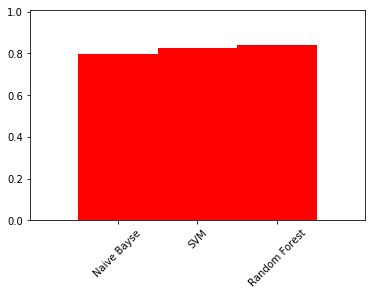

In [35]:
x = [1, 2, 3]
y = [metrics.roc_auc_score(test_bayse_prediction, test_labels),
     metrics.roc_auc_score(test_svm_prediction, test_labels),
     metrics.roc_auc_score(test_rf_prediction, test_labels)
     #metrics.roc_auc_score(test_gb_prediction, test_labels)
]
labels = ['Naive Bayse', 'SVM', 'Random Forest', 'Boosting']

#plt.hist(x, y, 'ro')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation=45)
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)


#pos = np.arange(len(X))
width = 1.0     # gives histogram aspect to the bar diagram
ax = plt.axes()
#ax.set_xticks(x + (width / 2))
ax.set_xticklabels(labels)

plt.bar(x, y, width, color='red')
plt.show()

### Text Analysis

In [22]:
words = naive.get_params()["vect"].get_feature_names()

# number of times each word appears in each positive message
pos_word_count = naive.get_params()["nb"].feature_count_[0, :]

# same for negative ones
neg_word_count = naive.get_params()["nb"].feature_count_[1, :]

ratio_pos_neg = []
for i in range(len(pos_word_count)) :
    ratio_pos_neg.append(pos_word_count[i]/neg_word_count[i])

words_frequencies = pd.DataFrame({"word":words, "positive":pos_word_count, "negative":neg_word_count, "ratio":ratio_pos_neg}).set_index("word")
words_frequencies.head()

words_frequencies.sort_values('ratio', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


,positive,negative,ratio
word,,,
astounding,1.216737,0.000000,inf
taxi,1.457085,0.067347,21.635450
gripping,1.175350,0.068389,17.186211
damon,2.564641,0.154770,16.570635
flawless,1.743607,0.127461,13.679532
religion,2.260367,0.170912,13.225300
outstanding,2.900588,0.229232,12.653482
scorsese,3.561519,0.305950,11.640869
magnificent,1.633454,0.159145,10.263951


## With the big data ?

In [ ]:
bigReviewList = []

mydir = "../Datasets/grand/train/txt_sentoken/" # Could need to change the path

# Load the positive examples 
for txt in listdir(mydir + "pos/"):
    if isfile(join(mydir + "pos/", txt)):
        review = open(join(mydir + "pos/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 0))
        
# Load the negative examples
for txt in listdir(mydir + "neg/"):
    if isfile(join(mydir + "neg/", txt)):
        review = open(join(mydir + "neg/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 1))
        